<a href="https://colab.research.google.com/github/Johnrre/MicroGrad/blob/main/grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))    # other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
            #other.grad = out.data * math.log(self.data) * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        return self * other ** (-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - math.pow(t, 2)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        y = math.exp(x)
        out = Value(y, (self, ), 'exp')

        def _backward():
            self.grad += y * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad = 1.0
        build_topo(self)

        for node in reversed(topo):
            node._backward()


In [ ]:
from graphviz import Digraph
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
#inputs to the neuron
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights of neuron
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.88137, label = 'b') #bias

x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh(); o.label = 'o'

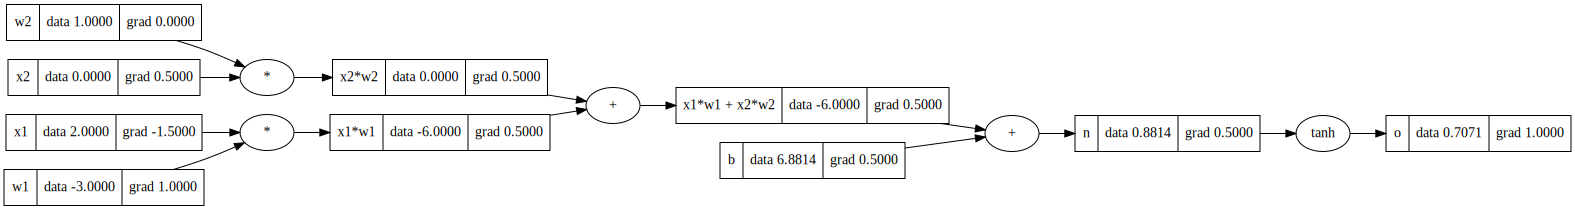

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
e = (2*n).exp()
o = (e - 1)/(e + 1)

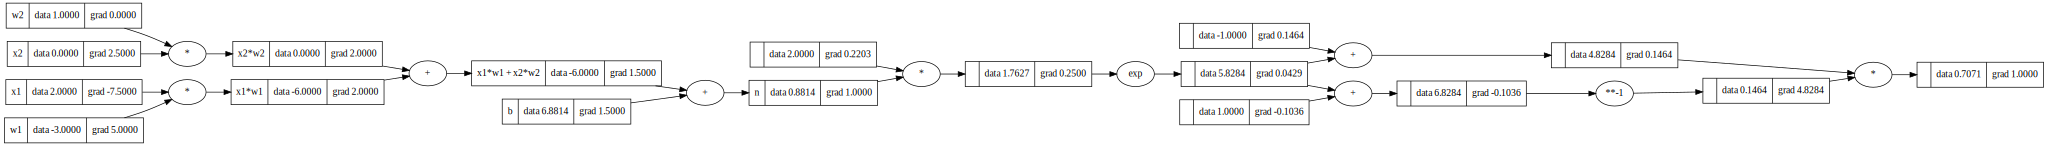

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
import torch
import random

In [ ]:
x1 = torch.Tensor([2.0]).double()         ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()         ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()        ; w1.requires_grad = True
w2 = torch.Tensor([1.0]). double()        ; w2.requires_grad = True

b = torch.Tensor([6.88137]). double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-------------------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071050214706146
-------------------------
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [ ]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  #Here we'll give some initial values to w and b
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for nuerons in self.neurons:
        #     ps = neurons.parameters
        #     params.extend(ps)
        # return params

class MLP:   # generates the neural network by taking n of inputs and n of nodes perlayer

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x = [2.0 ,3.0, -1.0]  #<--------------CHANGE THE INPUT VALUES HERE
n = MLP(3, [4, 4, 1])  #<---------------Here the first number represents the number of inputs, the next list of numbers represent the number of nodes in each layer starting from the first hidden layer
n(x)

Value(data=0.2523518236274112)

In [ ]:
len(n.parameters())

41

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys,ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 4.709480250743605
1 3.401101719207385
2 2.676786462864864
3 1.9802771814820361
4 1.2705067495263844
5 0.7139575364180198
6 0.4185330095795604
7 0.2777828972097811
8 0.2030064973283111
9 0.15821473233989922
10 0.1288466508843876
11 0.1082784188142767
12 0.09314675836917664
13 0.0815861982124525
14 0.07248708754828065
15 0.06515137112109042
16 0.05911946718780717
17 0.05407719658775068
18 0.04980289273708611
19 0.04613590844450027


In [ ]:
ypred

[Value(data=0.8851115622112375),
 Value(data=-0.933542217285759),
 Value(data=-0.8731276674562864),
 Value(data=0.8885400087090348)]

In [ ]:
ys[0] - ypred[0]

Value(data=0.11488843778876245)

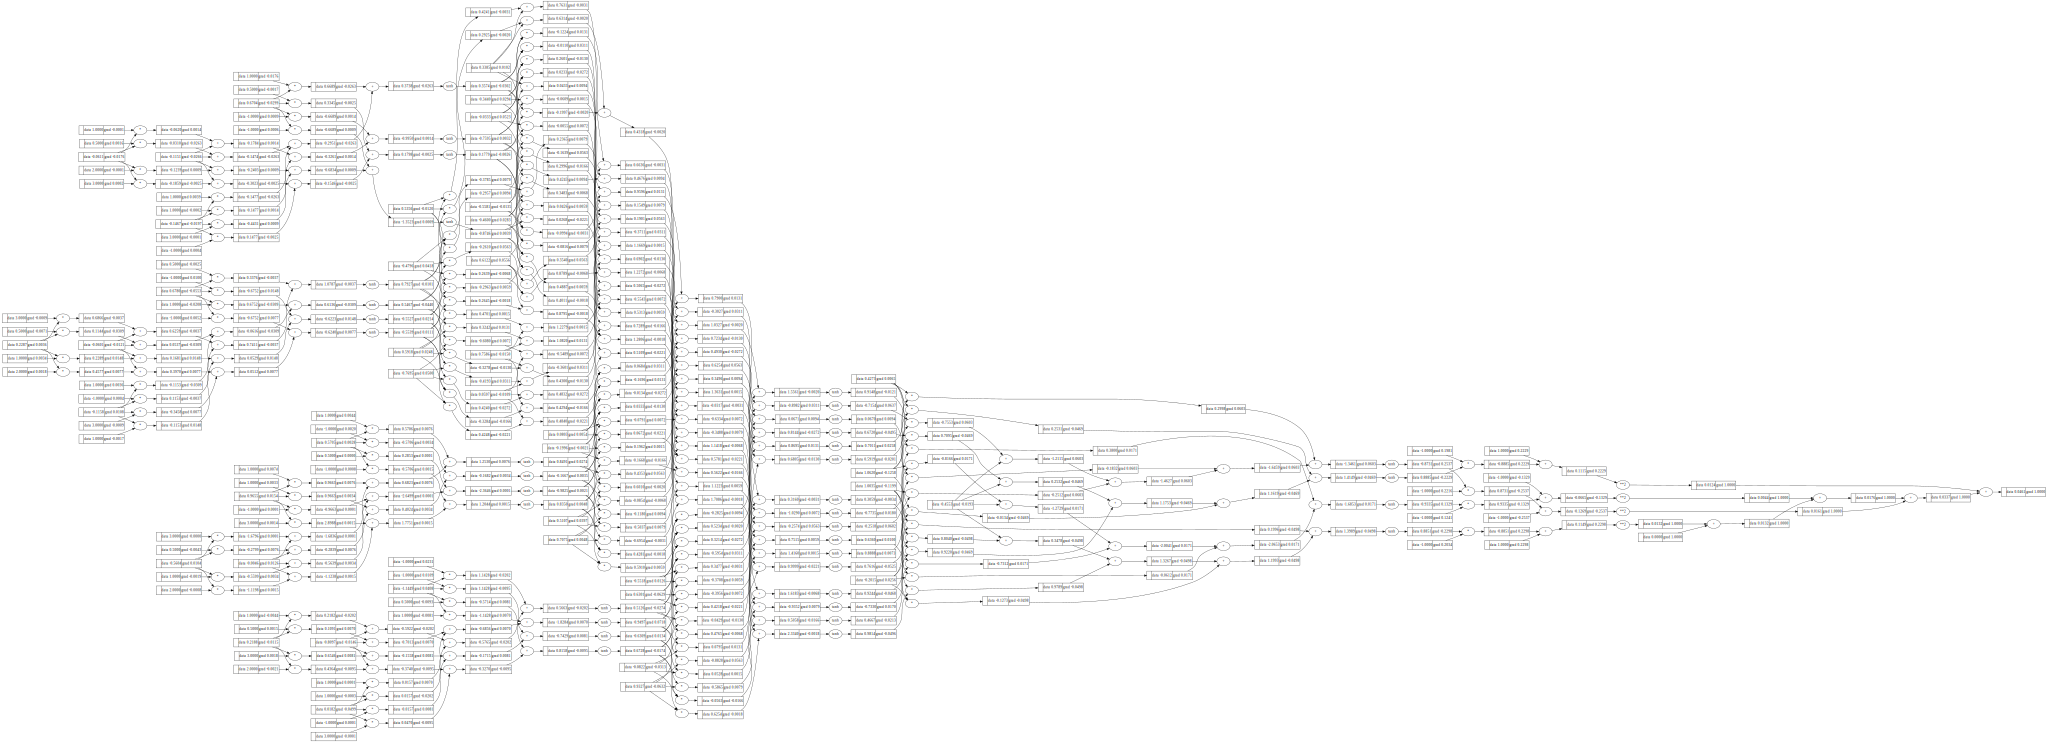

In [ ]:
draw_dot(loss)   #Heres the visual representation

In [ ]:
n.parameters()

[Value(data=-0.6411463723313426),
 Value(data=-0.7791726462899893),
 Value(data=-0.674928254759558),
 Value(data=-0.05501276523281608),
 Value(data=-1.0041918086360853),
 Value(data=0.04597839230572188),
 Value(data=-0.09117155187740968),
 Value(data=-0.8248688963346762),
 Value(data=-0.2777898653855562),
 Value(data=1.0053554398814992),
 Value(data=0.20809562799943884),
 Value(data=-0.34593856595777406),
 Value(data=-0.42819951172327925),
 Value(data=0.841677044172388),
 Value(data=-0.9407672396133674),
 Value(data=-0.3493572173929863),
 Value(data=0.041129195386023686),
 Value(data=0.4507954479896873),
 Value(data=-0.4139451932442137),
 Value(data=0.8236211401875624),
 Value(data=-0.05284555735839363),
 Value(data=0.8363513567387718),
 Value(data=-0.19078235052471276),
 Value(data=0.15114534995145307),
 Value(data=0.6908089909304779),
 Value(data=0.15860068146678252),
 Value(data=0.05175057747506432),
 Value(data=0.11310194511980674),
 Value(data=0.30639652010753515),
 Value(data=0.9